In [1]:
import os
import cv2
import numpy
import matplotlib.pyplot as plt
import time
import shutil
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")


2025-07-01 11:41:06.131313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751370066.333399      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751370066.389498      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset'

# List all folders
folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
print('Folders:', folders)



Folders: ['monocyte', 'ig', 'neutrophil', 'basophil', 'lymphocyte', 'erythroblast', 'eosinophil', 'platelet']


In [3]:
data_dir = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset'
data = [
    (os.path.join(data_dir, folder, file), folder)
    for folder in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, folder))
    for file in os.listdir(os.path.join(data_dir, folder))
    if os.path.isfile(os.path.join(data_dir, folder, file))
]

# first five entried of the data frame 

df = pd.DataFrame(data, columns=['filepaths', 'labels'])
print(df['labels'].value_counts())
print(df.head())


labels
neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: count, dtype: int64
                                           filepaths    labels
0  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
1  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
2  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
3  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
4  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte


#### df.describe() method in the pandas library for Python is used to generate descriptive statistics of a DataFrame

In [4]:
df.describe()

,filepaths,labels
count,17092,17092
unique,17092,8
top,/kaggle/input/blood-cells-image-dataset/bloodc...,neutrophil
freq,1,3329


#### df.info() method in the Pandas library provides a concise summary of a DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17092 entries, 0 to 17091
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  17092 non-null  object
 1   labels     17092 non-null  object
dtypes: object(2)
memory usage: 267.2+ KB


### Sample Visualizations

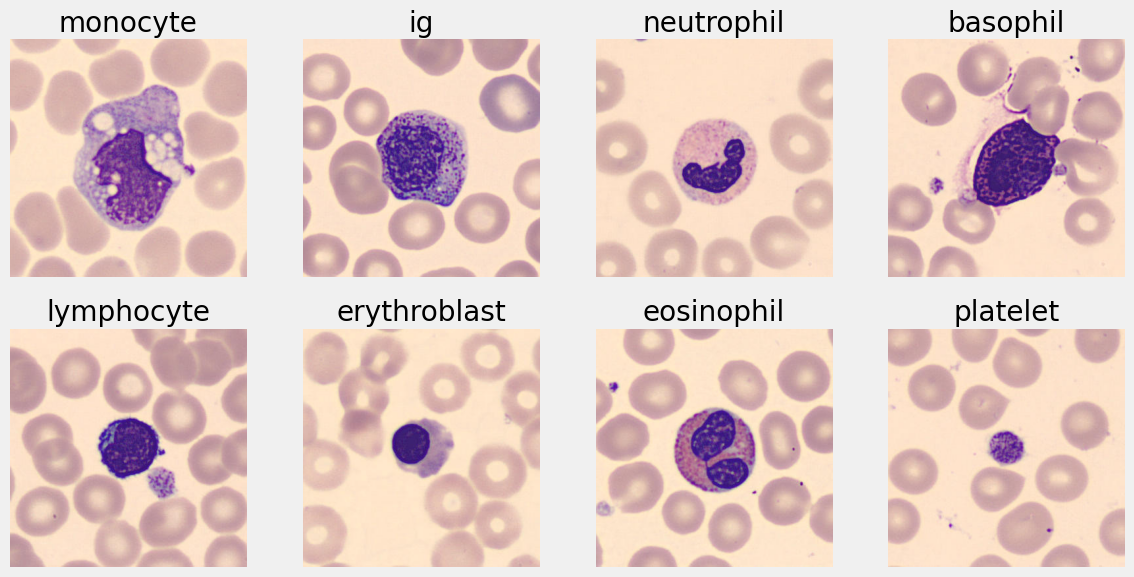

In [35]:
labels = df['labels'].unique()
n = len(labels)
plt.figure(figsize=(12, 6))

for i, label in enumerate(labels):
    img_path = df[df['labels'] == label]['filepaths'].iloc[0]
    img = cv2.imread(img_path)        # Reads image in BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Class Visualization

<Axes: title={'center': 'Class Distribution'}, xlabel='labels'>

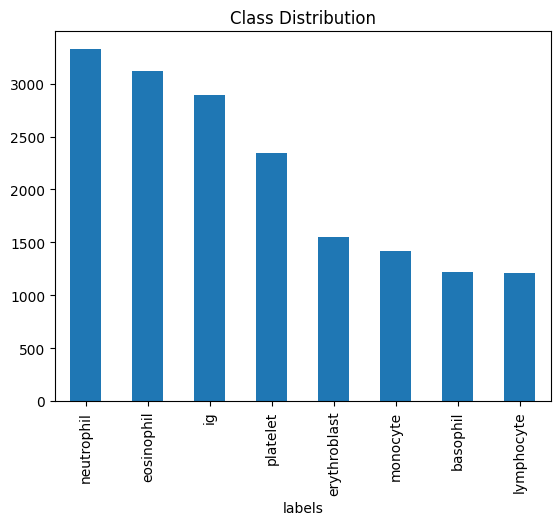

In [7]:
df['labels'].value_counts().plot(kind='bar', title='Class Distribution')


###  Image Size and Aspect Ratio Analysis

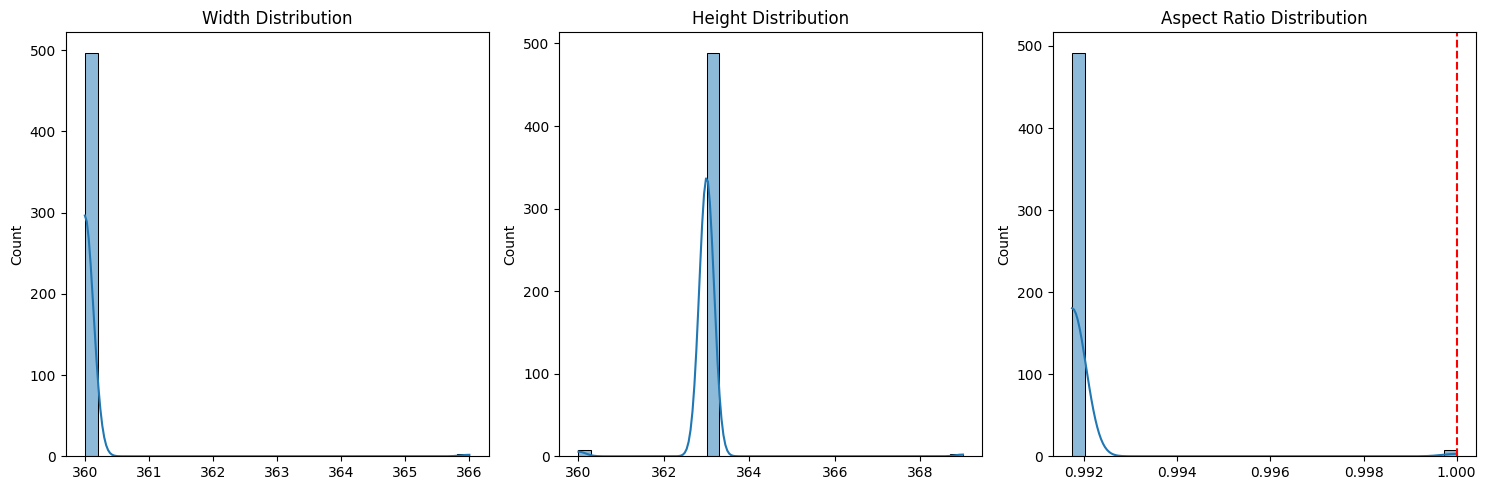

In [8]:
from PIL import Image
import numpy as np

# Collect image dimensions
dimensions = []
for path in df['filepaths'].sample(500):  # Sample for efficiency
    with Image.open(path) as img:
        dimensions.append(img.size)

# Convert to arrays
widths, heights = np.array(dimensions).T

# Plot distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(widths, bins=30, kde=True)
plt.title('Width Distribution')

plt.subplot(1, 3, 2)
sns.histplot(heights, bins=30, kde=True)
plt.title('Height Distribution')

plt.subplot(1, 3, 3)
sns.histplot(widths/heights, bins=30, kde=True)
plt.title('Aspect Ratio Distribution')
plt.axvline(1, color='r', linestyle='--')  # Square ratio line

plt.tight_layout()
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

# Assume df is your full DataFrame with columns 'filepaths' and 'labels'
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['labels'], random_state=42)


In [11]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 12305 validated image filenames belonging to 8 classes.
Found 1368 validated image filenames belonging to 8 classes.


In [20]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import EfficientNetB3


# 1. Define base model with EfficientNetB3
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling='max'
)

# 2. Build your model head with reduced regularization
class_count = len(train_gen.class_indices)  # Make sure train_gen is defined

model = models.Sequential([
    base_model,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(256, 
                 # Remove L2 regularization completely or make it very small
                 kernel_regularizer=regularizers.l2(0.0001),  # Reduced from 0.001
                 # Remove L1 regularization entirely
                 activation='relu'),
    layers.Dropout(rate=0.1, seed=123),  # Reduced from 0.2 to 0.1
    layers.Dense(class_count, activation='softmax')
])

# Unfreeze the entire base model or most of it
base_model.trainable = True

# Option A: Unfreeze all layers
# (No additional code needed, all layers are now trainable)

# Option B: Keep only the first 50 layers frozen (unfreeze last ~200+ layers)
for layer in base_model.layers[:50]:
    layer.trainable = False

# Compile with higher learning rate
model.compile(
    optimizer=Adam(learning_rate=5e-4),  # Increased from 1e-4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


I0000 00:00:1751370115.740931      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751370115.741734      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30


I0000 00:00:1751370202.185440     107 service.cc:148] XLA service 0x78c69c0036a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751370202.186551     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751370202.186575     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751370209.758155     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751370226.562909     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751370226.720344     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751370227.296274     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

238/385 ━━━━━━━━━━━━━━━━━━━━ 1:55 784ms/step - accuracy: 0.6980 - loss: 0.9907

E0000 00:00:1751370467.113921     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751370467.259219     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751370467.851083     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751370468.000055     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


385/385 ━━━━━━━━━━━━━━━━━━━━ 518s 986ms/step - accuracy: 0.7472 - loss: 0.8361 - val_accuracy: 0.8136 - val_loss: 0.5493 - learning_rate: 5.0000e-04
Epoch 2/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 278s 722ms/step - accuracy: 0.9288 - loss: 0.2699 - val_accuracy: 0.9518 - val_loss: 0.1809 - learning_rate: 5.0000e-04
Epoch 3/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 279s 723ms/step - accuracy: 0.9216 - loss: 0.3879 - val_accuracy: 0.9386 - val_loss: 0.2052 - learning_rate: 5.0000e-04
Epoch 4/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 279s 725ms/step - accuracy: 0.9576 - loss: 0.1665 - val_accuracy: 0.9488 - val_loss: 0.1845 - learning_rate: 5.0000e-04
Epoch 5/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 276s 717ms/step - accuracy: 0.9656 - loss: 0.1462 - val_accuracy: 0.8618 - val_loss: 0.4185 - learning_rate: 5.0000e-04
Epoch 6/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 273s 708ms/step - accuracy: 0.9734 - loss: 0.1208 - val_accuracy: 0.9766 - val_loss: 0.1114 - learning_rate: 2.5000e-04
Epoch 7/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 277s 719ms/

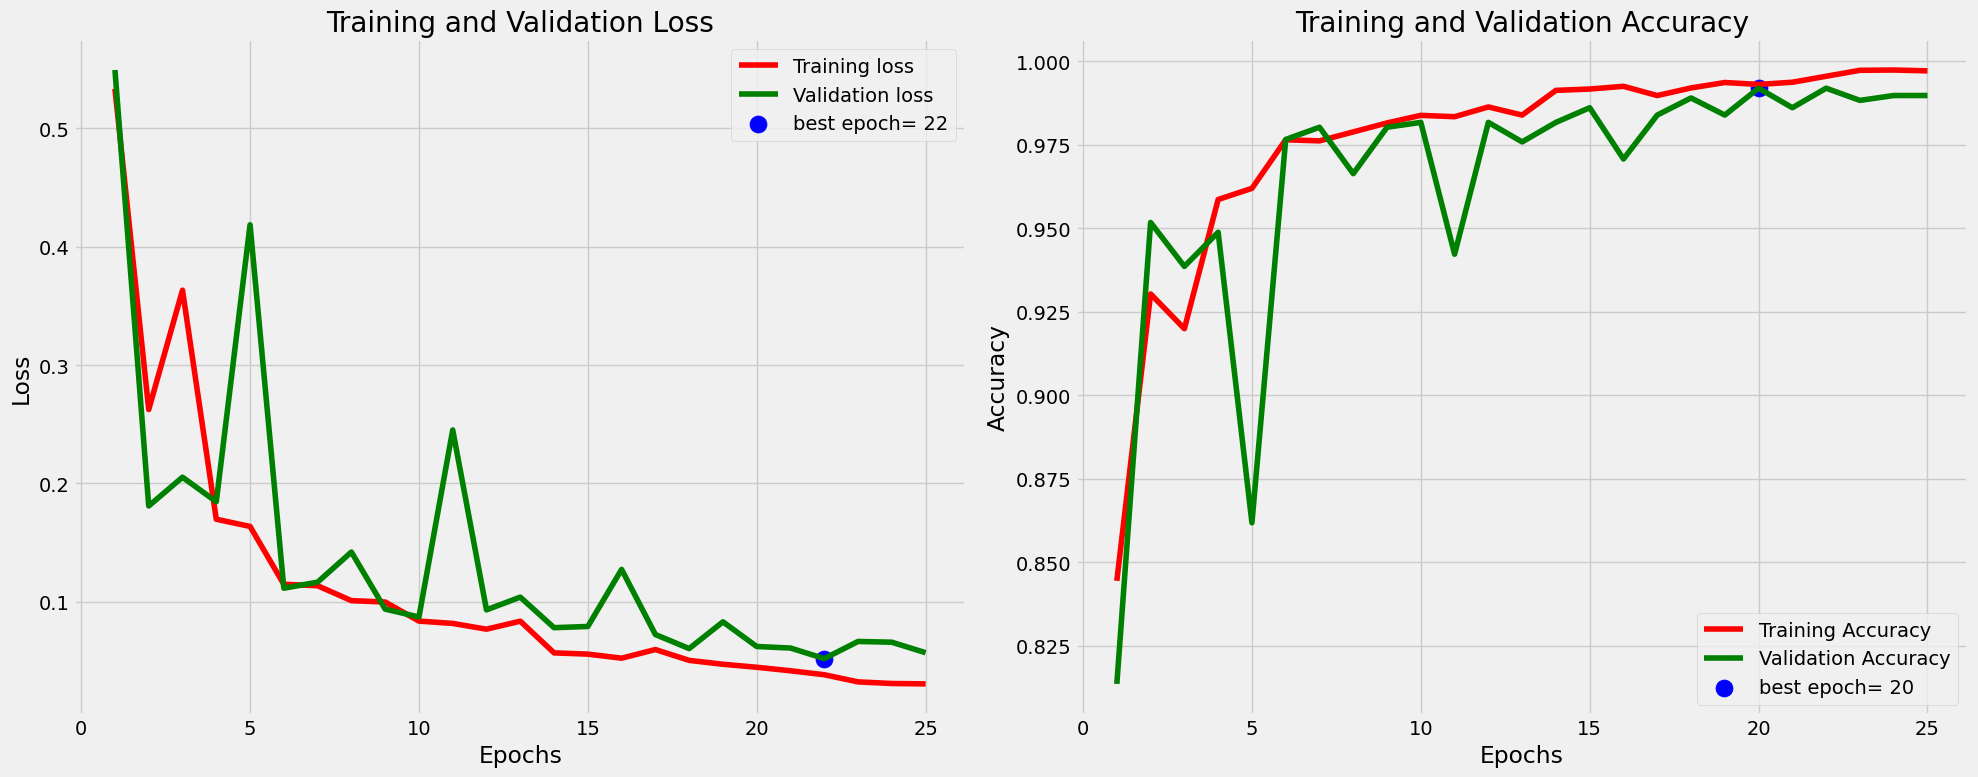

In [25]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',              # 🔁 name of the column with image file paths
    y_col='labels',                 # 🔁 name of the column with labels (optional for prediction only)
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',      # use 'input' if no labels (for prediction)
    shuffle=False
)


Found 3419 validated image filenames belonging to 8 classes.


In [29]:
import math

ts_length = len(test_df)
test_batch_size = 32


train_steps = train_gen.samples // train_gen.batch_size
val_steps = val_gen.samples // val_gen.batch_size
test_steps = math.ceil(test_gen.samples / test_gen.batch_size)


train_score = model.evaluate(train_gen, steps=train_steps, verbose=1)
valid_score = model.evaluate(val_gen, steps=val_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1]) 
print('-' * 20) 
print("Test Loss: ", test_score[0]) 
print("Test Accuracy: ", test_score[1]) 

384/384 ━━━━━━━━━━━━━━━━━━━━ 253s 660ms/step - accuracy: 0.9979 - loss: 0.0350
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9861 - loss: 0.0863
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.9848 - loss: 0.0663
Train Loss:  0.034493640065193176
Train Accuracy:  0.997802734375
--------------------
Validation Loss:  0.06280485540628433
Validation Accuracy:  0.991815447807312
--------------------
Test Loss:  0.07526791840791702
Test Accuracy:  0.9824510216712952


107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step


<Figure size 1700x1700 with 0 Axes>

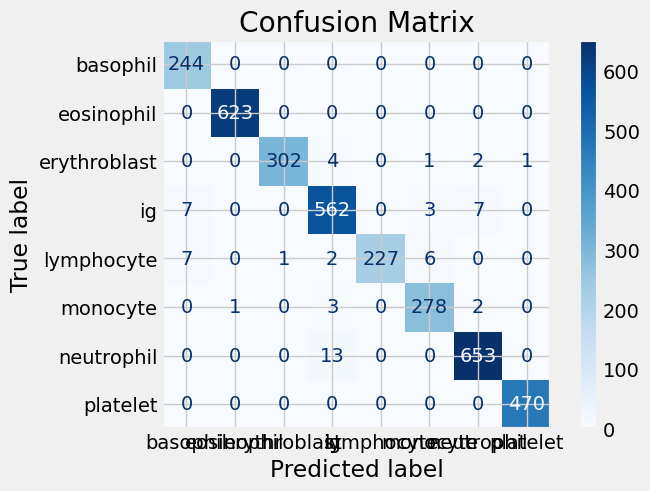

<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Predict on test data
y_pred_probs = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. True labels from test generator
y_true = test_gen.classes  # This works if test_gen was created with class_mode='categorical'

# 3. Class labels (optional, but helpful)
class_labels = list(test_gen.class_indices.keys())

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 5. Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(17, 17))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
plt.tight_layout()

In [34]:
from sklearn.metrics import classification_report

# 1. Predict on the test data
y_pred_probs = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Get the true labels
y_true = test_gen.classes

# 3. Get class label names
class_labels = list(test_gen.class_indices.keys())

# 4. Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)


107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step
Classification Report:

              precision    recall  f1-score   support

    basophil       0.95      1.00      0.97       244
  eosinophil       1.00      1.00      1.00       623
erythroblast       1.00      0.97      0.99       310
          ig       0.96      0.97      0.97       579
  lymphocyte       1.00      0.93      0.97       243
    monocyte       0.97      0.98      0.97       284
  neutrophil       0.98      0.98      0.98       666
    platelet       1.00      1.00      1.00       470

    accuracy                           0.98      3419
   macro avg       0.98      0.98      0.98      3419
weighted avg       0.98      0.98      0.98      3419



In [36]:
model.save('Blood_Cancer_Detection.h5')